
# Exercise 3: The 2D Ising model

## Background

We consider a square lattice of $N = w \times w$ sites.

Hamiltonian of model is
\begin{equation}
  E = -\Sigma_{i, j} J s_i s_j - \Sigma_i \mu H s_i
    = \frac{1}{\beta}(\Sigma_{i, j}a s_i s_j + \Sigma_i b s_i)
\end{equation}

## Libraries and preparations

In [1]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import numpy.typing as npt
import random
from typing import Callable
from time import time

# constant: what are the relative positions of my neighbours?
NEIGHBOURS: npt.NDArray = np.array([[0, 1], [0, -1], [1, 0], [-1, 0]])


## Functions

I have omitted some variables from the docstring to reduce clutter; grid
stores the spins, a, b are defined above, muH and J are the coupling constants
as above. w is the width of the grid.

In [2]:
def fix_seeds(seed: int):
    """!
    @brief fix random seeds for reproducibility

    @param seed seed to run RNG with for numpy and random
    """
    np.random.seed(seed)
    random.seed(seed)

def generate_board(w: int, invert: bool = False) -> npt.NDArray:
    """!
    @brief generate the checkerboard

    @param invert get the "opposite" checkerboard

    @return checkerboard - w * w array of 0 and 1
    """
    return (np.indices((w, w)).sum(axis = 0) + invert) % 2

def generate_masks(w: int) -> list:
    """!
    @brief return the two checkerboard masks
    """
    return [generate_board(w, invert) for invert in range(2)]

def generate_grid(w: int) -> npt.NDArray:
    """!
    @brief generate a grid of size w * w

    @return grid with randomised initial spins
    """
    grid = np.random.rand(w, w)
    # spins can only be 0 or 1
    grid = np.where(grid < 0.5, -1, 1) 
    return grid

def invert_unmasked(grid: npt.NDArray, mask: npt.ArrayLike) -> npt.NDArray:
    """!
    @brief invert unmasked positions of a grid

    @return inverted grid
    """
    return (np.ma.masked_array(grid, mask) * -1).data

def get_spin_spin_Eb_grid(grid: npt.NDArray, a: float, b: float) -> npt.NDArray:
    """!
    @brief calculate interaction energy * beta for every spin site

    @return grid containing E_{spin-spin} * beta at each site
    """
    w = grid.shape[0]  
    Eb_grid = np.zeros((w, w))

    # np.roll is faster for large w, but there's a terrible constant overhead to
    # this call. I'd rather avoid it whenever possible.
    if a != 0:
        for axis in range(2):
            for shift in (-1, 1):
                Eb_grid = Eb_grid + np.roll(grid, shift, axis = axis)

    return -a * np.multiply(grid, Eb_grid)

def get_magfield_Eb_grid(grid: npt.NDArray, a: float, b: float) -> npt.NDArray:
    """!
    @brief calculate coupling to magnetic field at each site

    @return grid containing E_{spin-magnetic field} * beta at each site
    """
    return -b * grid

def get_Eb_grid(grid: npt.NDArray, a: float, b: float, mask = None) -> npt.NDArray:
    """!
    @brief calculate energy for every spin site

    @param mask mask to apply before calculation
    """
    w = grid.shape[0]
    if mask is not None:
        grid = invert_unmasked(grid, mask)
    
    return get_spin_spin_Eb_grid(grid, a, b) + get_magfield_Eb_grid(grid, a, b)

def get_Eb(grid: npt.NDArray, a: float, b: float, mask = None) -> float:
    """!
    @brief calculate total energy * beta for the whole lattice

    @param mask mask to apply before calculation

    @return total energy * beta
    """
    w = grid.shape[0]
    if mask is not None:
        grid = invert_unmasked(grid, mask)
    
    # spin interaction when summed is double counted
    spin_spin_Eb = get_spin_spin_Eb_grid(grid, a, b).sum() / 2
    magfield_Eb = get_magfield_Eb_grid(grid, a, b).sum()
    return spin_spin_Eb + magfield_Eb

# NOTE where mask is 0 denotes flipped spins
def get_delta_Eb_grid(grid: npt.NDArray, mask: npt.NDArray,
                      a: float, b: float) -> npt.NDArray:
    """!
    @brief calculate Eb difference at each site before/after applying an inversion.

    @param mask a mask value of zero will flip the corresponding spin.
    """
    delta_grid = (get_Eb_grid(grid, a, b, mask) - get_Eb_grid(grid, a, b))
    return delta_grid

def flip(grid: npt.NDArray, mask: npt.NDArray, a: float, b: float) -> npt.NDArray:
    """!
    @brief attempt flips on the spins as in Metropolis-Hastings. Vectorised.

    @return resultant, flipped grid.
    """
    w = grid.shape[0]
    p_grid = np.random.rand(w, w)
    
    delta_Eb_grid = get_delta_Eb_grid(grid, mask, a, b)
    exp_delta_grid = np.exp(-delta_Eb_grid)
    # we don't really need the delta_Eb_grid < 0, since if that was true, this
    # exp_delta_grid > p_grid is also always true (exponential greater than 1)
    flip_mask = np.logical_not(exp_delta_grid > p_grid)

    # only when both masks give False can we flip a spin.
    # mask[x, y] == 0: this spin is a spin under a "flip-trial"
    # flip_mask[x, y] == 0: this spin meets Monte Carlo conditions
    flip_mask = np.logical_or(flip_mask, mask)

    flipped_grid = (np.ma.masked_array(grid, flip_mask) * -1).data
    return flipped_grid

def step_forward(grid: npt.NDArray, masks: list, a: float, b: float) -> npt.NDArray:
    """!
    @brief evolve one step in time. (use both masks, once for each)

    @return grid one step forward in time.
    """
    for mask in masks:
        grid = flip(grid, mask, a, b)
    return grid

def test():
    w = 2
    a = b = 1
    mask = generate_board(w, invert = False)
    grid = np.array([[-1, -1], [-1, 1]])
    print(grid)
    print(mask)
    print(get_Eb_grid(grid, a, b, mask = mask))
    print(get_delta_Eb_grid(grid, mask, a, b))
    masks = [generate_board(w, invert = i) for i in range(2)]
    print(flip(grid, mask, a, b))
    print(step_forward(grid, masks, a, b))

def get_M(grid: npt.NDArray) -> float:
    """!
    @brief get magnetization.
    """
    return grid.mean()

def simulate_for(grid: npt.NDArray, masks: npt.NDArray, T: int,
                 a: float, b: float) -> npt.NDArray:
    """!
    @brief simulate for given time.

    @param T time to simulate for.

    @return grid having been evolved for T steps.
    """
    for t in range(T):
        grid = step_forward(grid, masks, a, b)

    return grid

def get_average_M(grid: npt.NDArray, masks: npt.NDArray, T: int,
                 a: float, b: float) -> float:
    """!
    @brief get average M of provided grid over fixed number of steps.

    @param T average over time T.

    @return average of magnetisation M over specified time T
    """
    M_list = []  # list of quantities calculated from func.
    for t in range(T):
        M_list.append(get_M(grid)) 
        grid = step_forward(grid, masks, a, b)

    return np.average(M_list)

def get_C(grid: npt.NDArray, masks: npt.NDArray, T: int, temp: float,
          a: float, b: float) -> float:
    """!
    @brief get heat capacity of system through fluctuation-dissipation thm.

    @param T simulation time
    @param temp temperature of system
    """
    Eb_list = []
    for t in range(T):
        Eb_list.append(get_Eb(grid, a, b))
        grid = step_forward(grid, masks, a, b)

    Eb_list = np.array(Eb_list)
    C = np.var(Eb_list * temp) / (temp ** 2)
    return C

## Time evolution of lattice

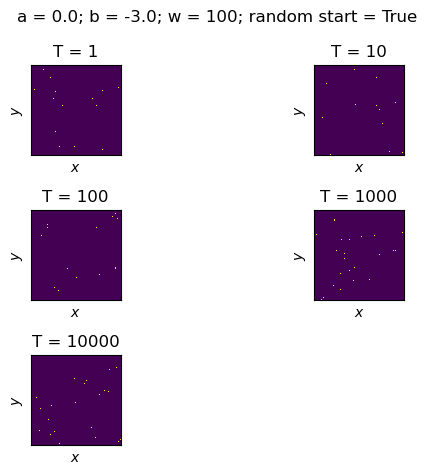

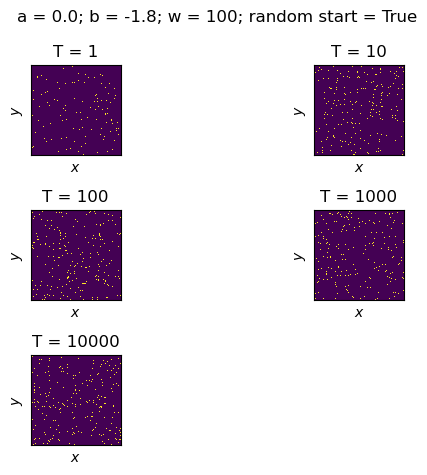

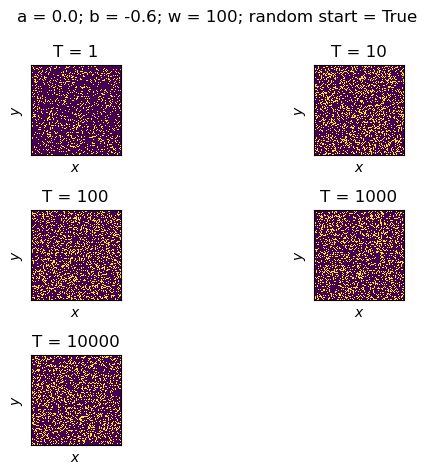

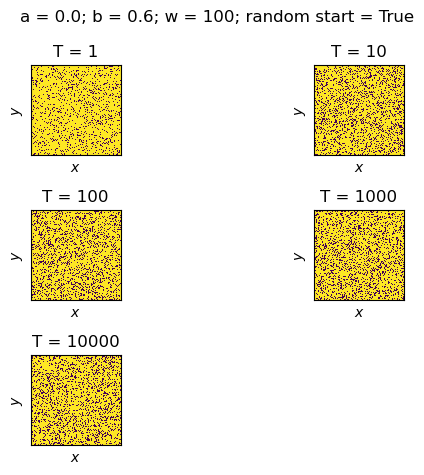

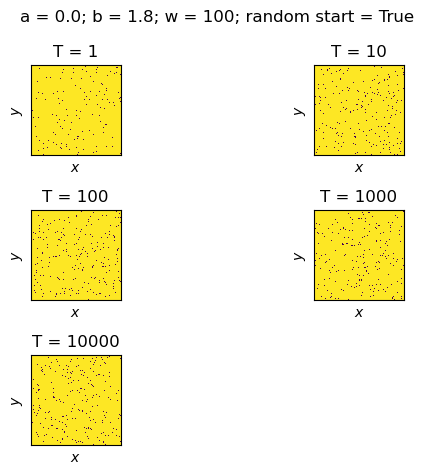

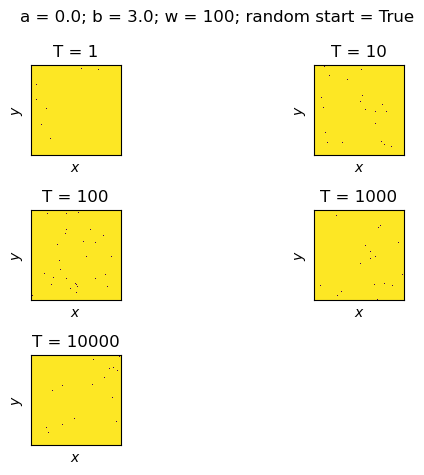

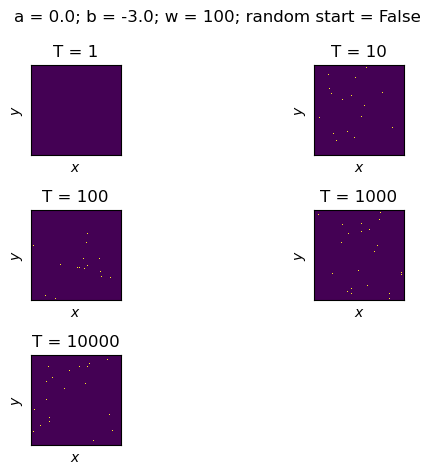

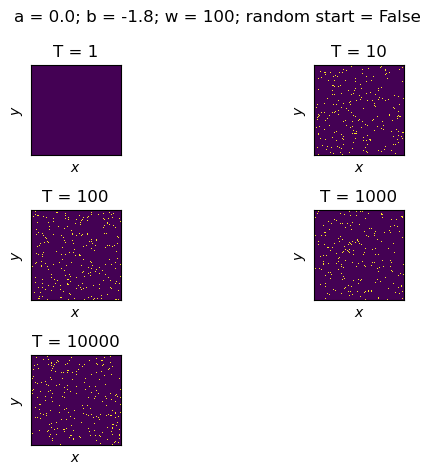

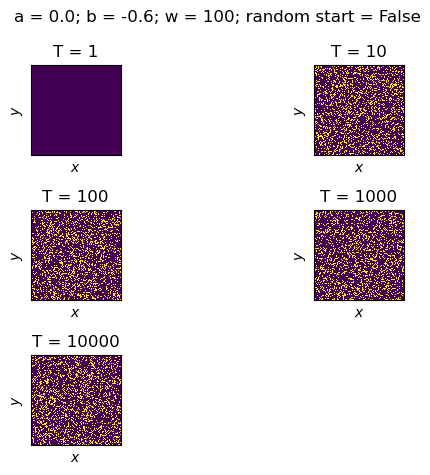

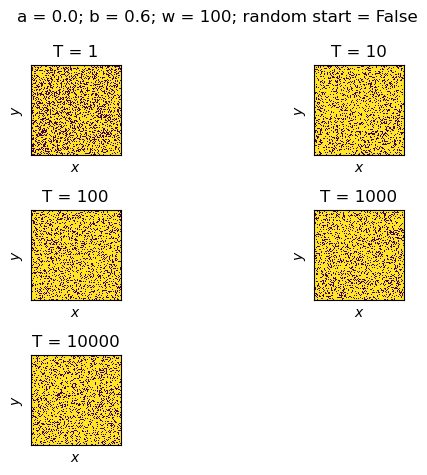

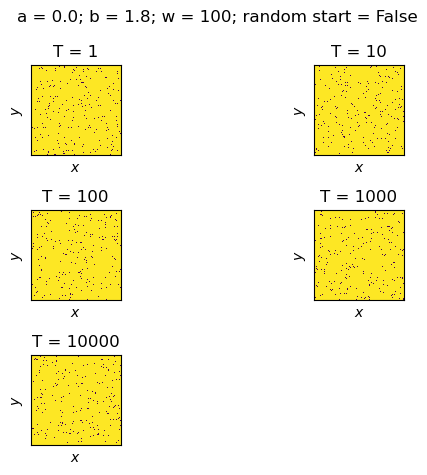

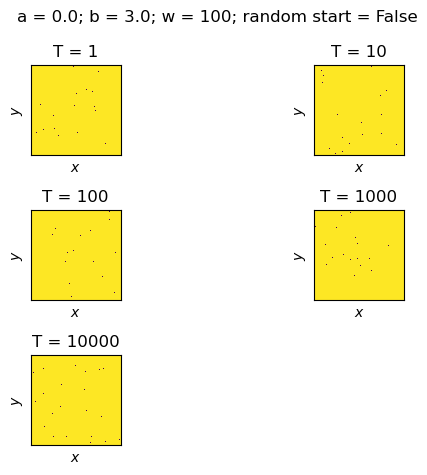

In [3]:
def time_evolution_plot(w: int, a: float, b: float, rand: bool = True):
    """!
    @brief plot how spins in the grid evolves in time (snapshots)

    @param rand whether to start with randomised grid or uniform 1's.
    """
    T = [10 ** x for x in range(5)]
    grid = generate_grid(w)
    if not rand:
        grid = np.ones([w, w])
    masks = generate_masks(w)
    fig, axs = plt.subplots(3, 2)
    axs[2, 1].remove()

    for i in range(len(T)):
        TT = T[i]
        row = int(i / 2)
        col = i % 2
        ax = axs[row, col]
        ax.matshow(simulate_for(grid, masks, TT, a, b))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f'T = {TT}')
        ax.set_xlabel('$x$')
        ax.set_ylabel('$y$')
    fig.suptitle(f"a = {a:.1f}; b = {b:.1f}; w = {w}; random start = {rand}")
    plt.tight_layout()
    plt.show()

# if b = 0 we get "guaranteed flips" every time, and it's not much to see...
fix_seeds(0)
for b in np.linspace(-3, 3, 6):
    time_evolution_plot(w = 100, a = 0, b = b, rand = True)

for b in np.linspace(-3, 3, 6):
    time_evolution_plot(w = 100, a = 0, b = b, rand = False)

## Time evolution of magnetization

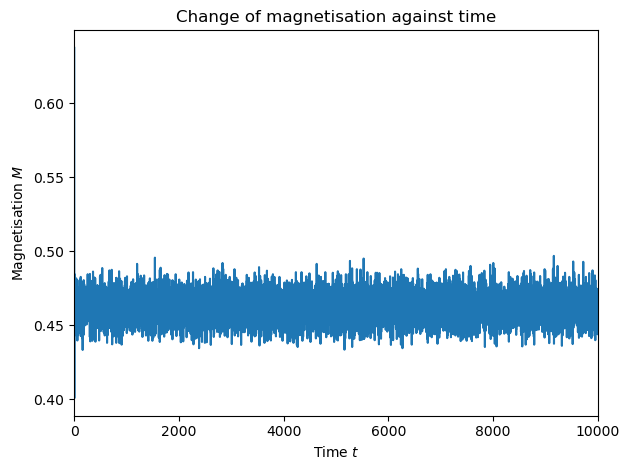

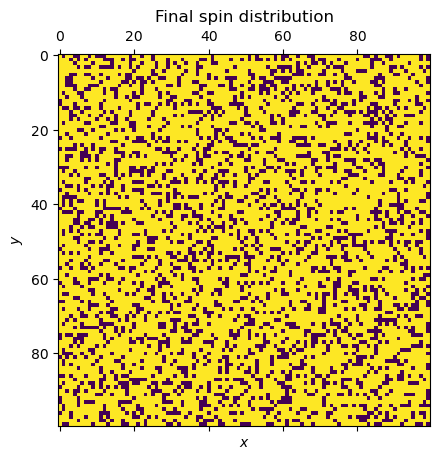

In [4]:
def M_against_t(w: int, a: float, b: float, T: int, rand: bool = True):
    """!
    @brief plot mean magnetization of the grid against time

    @param T evolution time
    @param rand whether to start with randomised grid, or uniform 1's.
    """
    grid = generate_grid(w)
    masks = generate_masks(w)

    if not rand:
        grid = np.ones([w, w])

    M_list = []
    for t in range(T):
        grid = step_forward(grid, masks, a, b)
        M_list.append(get_M(grid))

    plt.plot(range(T), M_list)
    plt.xlim(0, T)
    plt.xlabel('Time $t$')
    plt.ylabel('Magnetisation $M$')
    plt.title('Change of magnetisation against time')
    plt.tight_layout()
    plt.show()

    plt.matshow(grid)
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.title('Final spin distribution')
    plt.show()

fix_seeds(0)
M_against_t(w = 100, a = 0, b = 0.5, T = int(1e4))


We can notice that because of the Monte Carlo nature of our method, the spin
never settles down to a single value; Instead significant fluctuation is
always present. However large fluctuations do die off very quickly (initial
few cycles).


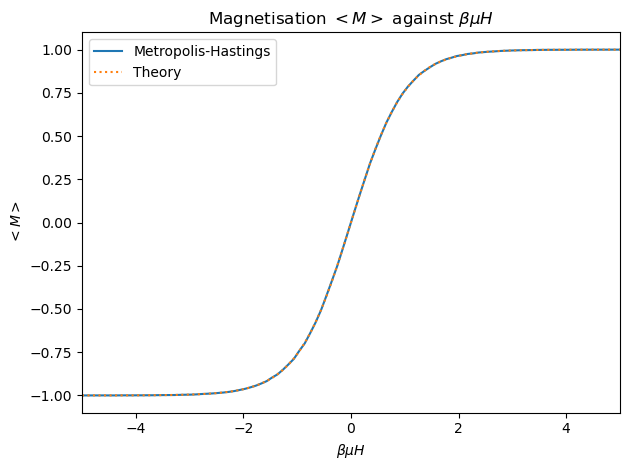

In [5]:
def no_coupling_M_against_b(w: int, b: npt.ArrayLike, T: int, T_avg: int):
    """!
    @brief plot equilibrium magnetization against parameter b

    @param T simulation time before we assume equilibrium is reached
    @param T_avg time to take average
    """
    a = 0
    grid = generate_grid(w)
    masks = generate_masks(w)

    M_list = []

    for bb in b:
        # recycles previous grid as result will be similar
        # that is we start near equilibrium
        grid = simulate_for(grid, masks, T, a, bb)
        M_list.append(get_average_M(grid, masks, T_avg, a, bb))

    plt.plot(b, M_list, label = 'Metropolis-Hastings')
    plt.title('Magnetisation $<M>$ against $\\beta \\mu H$')
    plt.xlabel('$\\beta \\mu H$')
    plt.ylabel('$<M>$')
    plt.xlim(-5, 5)
    plt.plot(b, np.tanh(b), label = 'Theory', linestyle = 'dotted')
    plt.legend()
    plt.tight_layout()
    plt.show()

fix_seeds(0)
no_coupling_M_against_b(w = 50, b = np.linspace(-5, 5, 100), T = 400, T_avg = 50)


Very good match indeed...



## Core Task 2: spin coupling only

For this we set $b = 0$, $a = \pm 0.2$.

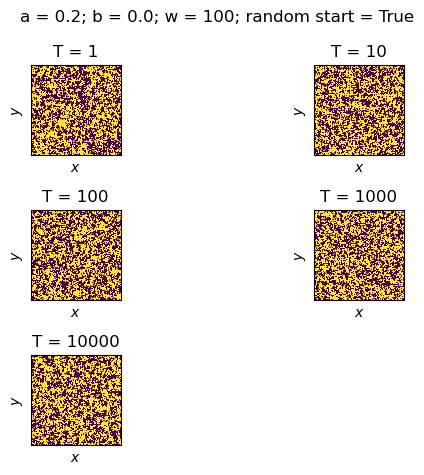

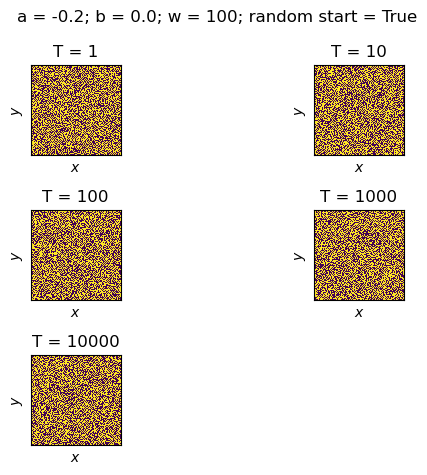

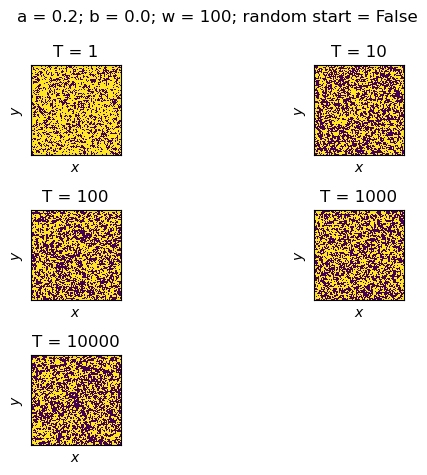

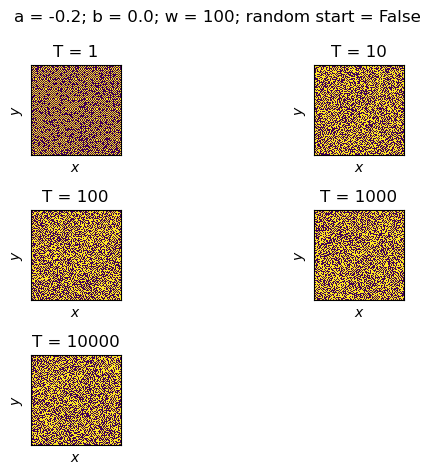

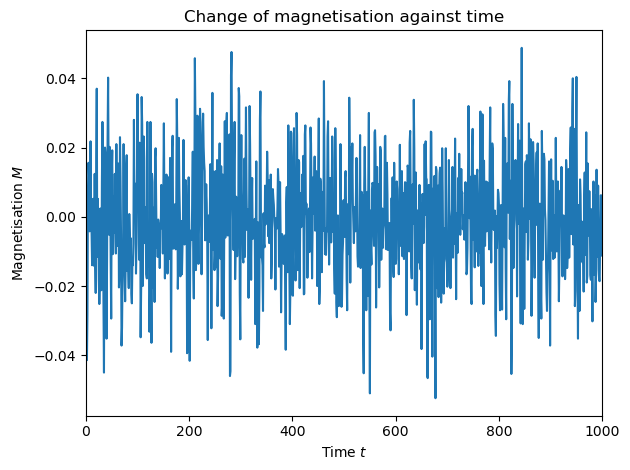

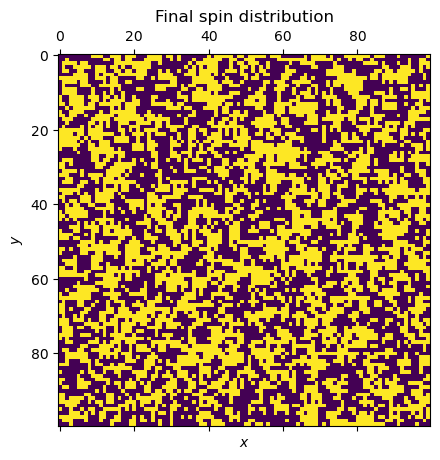

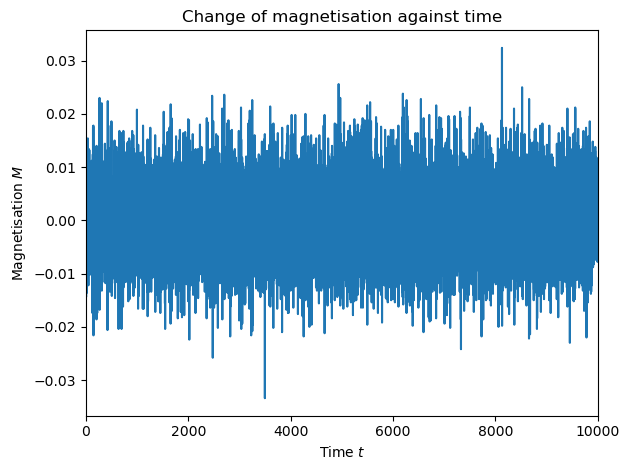

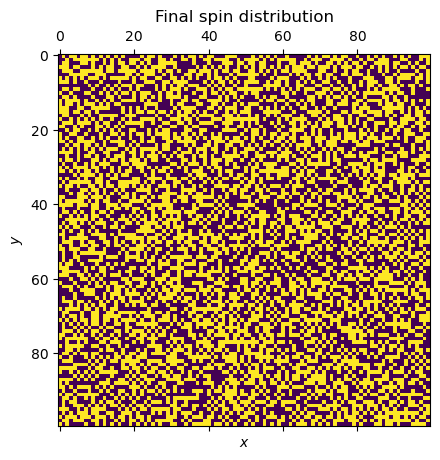

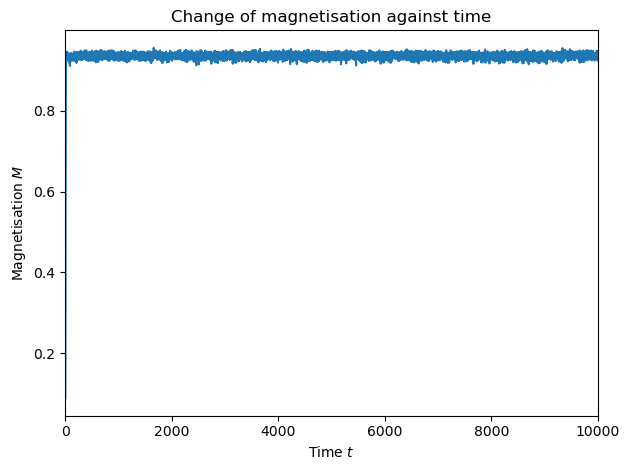

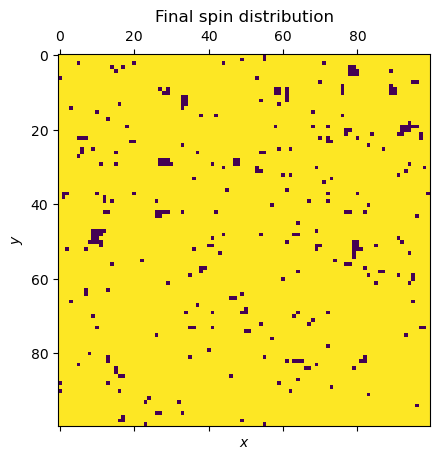

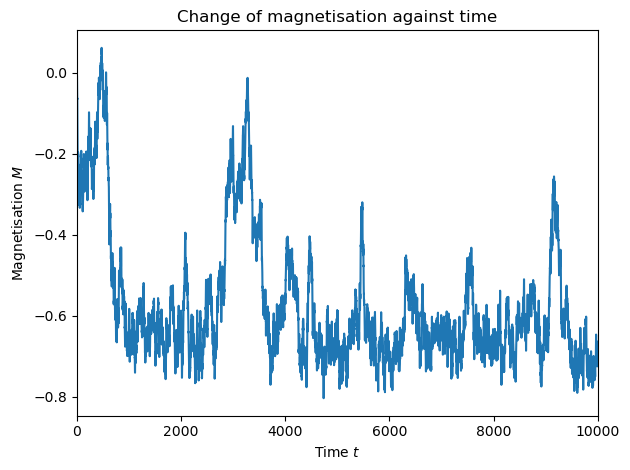

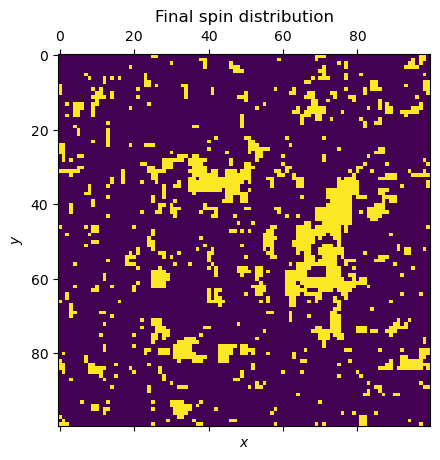

In [6]:
fix_seeds(0)
time_evolution_plot(w = 100, a = 0.2, b = 0, rand = True)
time_evolution_plot(w = 100, a = -0.2, b = 0, rand = True)

time_evolution_plot(w = 100, a = 0.2, b = 0, rand = False)
time_evolution_plot(w = 100, a = -0.2, b = 0, rand = False)

M_against_t(w = 100, a = 0.2, b = 0, T = int(1e3))
M_against_t(w = 100, a = -0.2, b = 0, T = int(1e4))
M_against_t(w = 100, a = 0.5, b = 0.05, T = int(1e4))
M_against_t(w = 100, a = np.log(1 + np.sqrt(2)) / 2, b = 0, T = int(1e4))


At small values of $a = \pm 0.2$, the system sees some fluctuation about
expected mean $\left<M\right> = 0$. As we get close to the critical point, the
fluctuation significantly increases.

At larger values, sometimes the system settle into rectangular blocks of
opposite spin and evolves very slowly in time. It appears that by introducing
a perturbing, symmetry-breaking magnetic field this can be alleviated to some
extent.

Comparison with analytic result. Critical temperature in terms of the
parameter $b = J \beta$ is $b_c = \frac{\ln{1 + \sqrt{2}}}{2}$. Above this
temperature the system can have nonzero mean magnetisation.



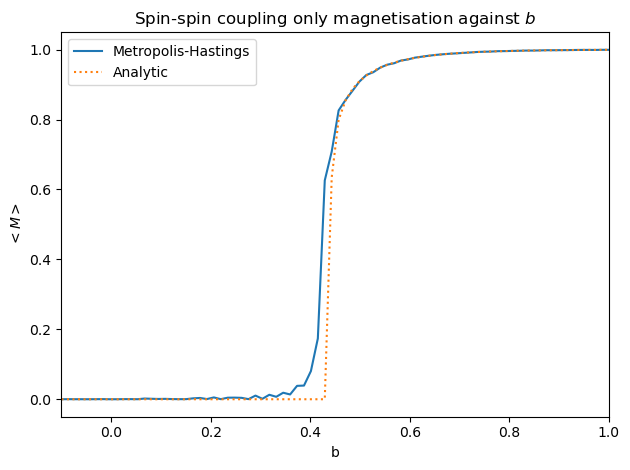

In [7]:
def coupling_only_M_against_a(w: float, a: npt.ArrayLike,
                              T: int, T_avg: int):
    """!
    @brief plot equilibrium magnetization M against parameter a

    @param T simulation time
    @param T_avg average time
    """
    b = 0 
    M_list = []
    grid = generate_grid(w)
    masks = generate_masks(w)
    
    for aa in a:
        grid = simulate_for(grid, masks, T, aa, b)
        M_list.append(abs(get_average_M(grid, masks, T_avg, aa, b)))

    def analytic(a: npt.ArrayLike) -> npt.ArrayLike:
        # not as good as np.where, but that method appears to evaluate both
        # branches at the same time, and then complain about roots of negative
        # numbers when I explicitly tell it NOT to do that... :)
        return [(1 - np.sinh(2 * aa) ** (-4)) ** (1 / 8)
                if aa > np.log(1 + np.sqrt(2)) / 2 else 0 for aa in a]
   
    plt.plot(a, M_list, label = 'Metropolis-Hastings')
    plt.plot(a, analytic(a), label = 'Analytic', linestyle = 'dotted')
    plt.legend()
    plt.xlim(min(a), max(a))
    plt.title('Spin-spin coupling only magnetisation against $b$')
    plt.xlabel('b')
    plt.ylabel('$<M>$')
    plt.tight_layout()
    plt.show()

fix_seeds(0)
coupling_only_M_against_a(w = 30, a = np.linspace(-0.1, 1, 80),
                          T = 500, T_avg = 500)

The method does reproduce the analytical formula, albeit sometimes with a bit
of deviation. Increasing the size of the lattice, and the simulation times
should improve the result, as the analytical result is for an infinite lattice.



## Supplementary Task: heat capacity near phase transition. 

Note that, we have set the Boltzmann constant $k_B$ to constant for
convenience's sake - we don't know the size of the individual spins anyway.
Here we take $J$ and $\mu H$ to be constant.

We choose the specific values $J = 1$, $b = 0 = muH$. The temperature range
is then chosen to cover the critical temperature range, which for our scale
will appear at $T = \frac{2}{\ln{1 + \sqrt{2}}} \approx 2.27$.

10
14
18
22
26
30


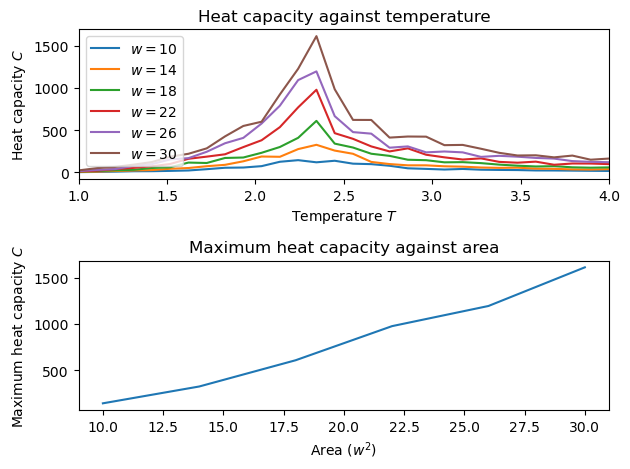

In [8]:
def C_against_temp_plot(w_list: npt.ArrayLike, temp_list: npt.ArrayLike,
                        T: int, T_samp: int, J: float, muH: float):
    """!
    @brief plot heat capacity against temperature

    @param w_list list of system sizes to consider
    @param temp_list list of temperature to consider
    @param T simulation time
    @param T_samp sampling time for heat capacity calculation
    @param J spin-spin coupling constant
    @param muH magnetic coupling strength
    """
    plt.subplot(2, 1, 1)
    Cmax_list = []
    for w in w_list:
        print(w)
        grid = generate_grid(w)
        masks = generate_masks(w)
        C_list = []
        
        for temp in temp_list:
            a = J / temp 
            b = muH / temp
            # so next simulation starts from previous equilibrium
            grid = simulate_for(grid, masks, T, a, b)
            C = get_C(grid, masks, T_samp, temp, a, b)
            C_list.append(C)
        
        plt.plot(temp_list, C_list, label = f'$w = {w}$')
        Cmax_list.append(max(C_list))

    plt.xlabel('Temperature $T$')
    plt.ylabel('Heat capacity $C$')
    plt.title('Heat capacity against temperature')
    plt.legend()
    plt.xlim(min(temp_list), max(temp_list))

    plt.subplot(2, 1, 2)
    plt.title('Maximum heat capacity against area')
    plt.xlabel('Area ($w^2$)')
    plt.ylabel('Maximum heat capacity $C$')
    plt.plot(w_list, Cmax_list)
    plt.tight_layout()
    plt.show()


fix_seeds(0)
C_against_temp_plot(w_list = np.linspace(10, 30, 6, dtype = int),
                    temp_list = np.linspace(1, 4, 30),
                    T = 400,
                    T_samp = 400,
                    J = 1,
                    muH = 0)


We can see that around the critical temperature a peak in heat capacity
appears, which is characteristic of phase transitions.

The (maximum in) heat capacity has a near linear relationship with the number
of spins ($w^2$). This is to be expected since heat capacity is extensive -
linearly depends on size of system.